# Regression

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle


## Tool Function

### 准确率和混淆矩阵

In [2]:
'''
通过矩阵方法计算预测正确率和混淆矩阵
'''
# 通过矩阵计算正确率
def calPrecRate(predResult, origResult):
    predResult = np.matrix(predResult)
    origResult = np.matrix(origResult)
    m, _n = predResult.shape

    return float(sum(predResult == origResult)) / m

# 通过矩阵计算计算混淆矩阵
def calConfMatrix(predResult, origResult):
    predResult = np.matrix(predResult)
    origResult = np.matrix(origResult)
    m, _n = predResult.shape

    # 通过计算准确率的方式计算混淆矩阵的四个值，最终返回混淆矩阵（pd.DataFrame）和正确率
    zeroZero = calPrecRate(predResult + origResult, np.zeros((m, 1))) * m        # 0 + 0 = 0
    zeroOne = calPrecRate(predResult - origResult, np.ones((m, 1))) * m          # 1 - 0 = 1
    oneZero = calPrecRate(origResult - predResult, np.ones((m, 1))) * m          # 1 - 0 = 1
    oneOne = calPrecRate(predResult + origResult, 2 * np.ones((m, 1))) * m       # 1 + 1 = 2

    confMatrix = pd.DataFrame([[oneOne, oneZero], [zeroOne, zeroZero]], columns=['one', 'zero'], index=['one', 'zero'])
    accuracy = (zeroZero + oneOne) / (zeroZero + oneOne + zeroOne + oneZero)
    return confMatrix, accuracy

# 通过混淆矩阵计算准确率、召回率和F1-Score
def calPRF(confMatrix):
    precision = confMatrix.iloc[0, 0] / (confMatrix.iloc[0, 0] + confMatrix.iloc[1, 0])
    recall = confMatrix.iloc[0, 0] / (confMatrix.iloc[0, 0] + confMatrix.iloc[0, 1])
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

### Error Rate

In [3]:
'''
计算Error Rate
'''
def calErrorRate(errorArray):
    errorVec = np.array(errorArray).reshape((1, -1))
    errorVec = np.abs(errorVec)
    return errorVec.sum() / errorVec.shape[1]

### Smooth Line

In [4]:
'''
按照一定步长对lst进行采样
'''
def smoothLine(lst, step):
    result = []
    for i in range(len(lst) // step + 1):
        lstF = lst[i * step:(i + 1) * step]
        if len(lstF) > 0:
            av = np.average(lstF)
            var = np.var(lstF) ** 0.5
            result.append([i * step, av, av - var, av + var])
    return result

## Logistic Regression代码实现

### Sigmoid函数

In [5]:
def sigmoid(inX):
    return 1 / (1 + np.exp(-inX))

# 避免上溢报错问题
def sigmoid(inX):
    x_shape = inX.shape                                      # 获取输入矩阵形状
    x = np.array(inX).ravel()                                # 铺平
    y = []
    for i in range(len(x)):
        if  x[i] >= 0:
            y.append(1 / (1 + np.exp(-x[i])))
        else:
            y.append(np.exp(x[i]) / (1 + np.exp(x[i])))      # 当某一个元素小于0时，用另一个公式计算，解决上溢问题
    return np.matrix(np.array(y).reshape(inX.shape))

### 批量梯度上升算法

In [6]:
'''
批量Logistic Regression梯度上升算法
'''
def batchGradAscent(dataMatIn, classLabels, maxCycles=2500):
    # 将输入转化为np的matrix数据类型
    dataMatrix = np.matrix(dataMatIn, copy=True)
    labelMat = np.matrix(classLabels)

    m, n = dataMatrix.shape
    weights = np.ones((n, 1))                                  # 将权重初始化为1

    # 循环进行梯度上升，最多循环maxCycles次
    for k in range(maxCycles):
        alpha = 1 / (1 + k)
        h = sigmoid(dataMatrix * weights)                      # 计算当前weights下logistic regression分类结果
        error = (labelMat - h)                                 # 计算当前weights下的误差
        weights += alpha * dataMatrix.transpose() * error      # 梯度上升
    return weights

### 随机梯度上升算法

In [7]:
'''
随机梯度上升算法
'''
def stocGradAscent(dataMatIn, classLabels, alpha=0.01):
    # 将输入转化为np的matrix数据类型
    dataMatrix = np.matrix(dataMatIn, copy=True)
    labelMat = np.matrix(classLabels).transpose()

    m, n = dataMatrix.shape
    weights = np.ones((n, 1)) # 生成初始weights
    # 遍历训练集的每一行
    for i in range(m):
        test = dataMatrix[i]
        h = sigmoid(dataMatrix[i] * weights)
        error = float(labelMat[i] - h)
        weights += alpha * error * dataMatrix[i].reshape((n, 1))
    return weights


In [8]:
'''
改进的随机梯度上升算法
相比起原函数，设置了更新全样本的论数：numIter，即更新numIter轮，每一轮更新m次，一次根据一条数据进行更新
每次随机从数据集中抽取一条数据更新weights，且不可重复
'''
def stocGradAscentImproved(dataMatIn, classLabels, numIter=2500):
    # 将输入转化为np的matrix数据类型
    dataMatrix = np.matrix(dataMatIn, copy=True)
    labelMat = list(classLabels.ravel())
    m, n = dataMatrix.shape
    
    weights = np.ones((n, 1))                                                   # 生成初始weights
    # 外循环：numIter次
    for j in range(numIter):
        dataIndex = list(range(m))
        # 内循环：dataMatrix行数
        for i in range(m):
            alpha = 4 / (4.0 + j + i)                                           # 随着轮数的增加，更新的步幅变小
            randIndex = dataIndex.pop(random.randint(0, len(dataIndex) - 1))    # 获取dataMatrix中的随机一行
            # 更新weights                                                        #（不放回抽样）
            h = sigmoid(dataMatrix[randIndex] * weights)
            error = float(labelMat[randIndex] - h)
            weights += alpha * error * dataMatrix[randIndex].reshape((n, 1))
    return weights

### 小批量随机梯度上升

In [9]:
def checkGradThreshold(grad, threshold):
    '''
    当有一个元素比阈值大，就返回True
    '''
    check = np.abs(grad) - threshold
    if True in (check > 0).ravel():
        return True
    else:
        return False

def miniBatchGradAscent(dataMatIn, classLabels, batchSize=10, gradThreshold=1e-10, \
    jThreshold=0.9, maxCycles=2000):
    # 初始化参数
    m, n = dataMatIn.shape
    dataMatrix = np.matrix(dataMatIn)
    labelMat = np.matrix(np.array(classLabels).reshape((m, 1)))
    weights = np.matrix(np.ones((n, 1)))
    dataIndex = list(range(len(dataMatrix)))
    
    # 最多循环maxCycles次
    for i in range(maxCycles):
        dataIndex = list(range(m))
        random.shuffle(dataIndex)
        errorRate = 0
        # 获取随机小批量数据
        for j in range(math.floor(m / batchSize) + 1):
            randomIndex = dataIndex[batchSize * j:batchSize * j + batchSize]  # b，从数据中抽取batchSize行用于更新数据
            if len(randomIndex) > 0:
                alpha = 4 / (4 + i)                                           # 随着轮数的增加，更新的步幅变小
                batchData = dataMatrix[randomIndex]                           # b * n
                batchLabels = labelMat[randomIndex]                           # b * 1

                # 用小批量数据更新weights
                h = sigmoid(batchData * weights)                              # b * 1
                error = batchLabels - h                                       # b * 1
                errorRate += np.abs(error).sum()
                gradient = batchData.transpose() * error                      # n * 1
                if not checkGradThreshold(gradient, gradThreshold):
                    return weights
                weights += alpha * gradient
        
        if 1 - errorRate / m > jThreshold:
            return weights
    return weights

In [10]:
'''
分类函数，根据回归得到的weights计算输入的分类结果
'''
# 对行分类
def classifyVector(inX, weights):
    prob = float(sigmoid(inX.T * weights))
    if prob > 0.5:
        return 1
    else:
        return 0

# 对矩阵分类，用矩阵运算，比迭代调用classifyVector快很多
def classifyMatrix(inX, weights):
    inX = np.matrix(inX)
    weights = np.matrix(weights)
    probs = sigmoid(inX * weights)
    return np.round(probs)


## 预测疝气病（课本数据）

### 导入数据集

In [11]:
# 导入训练数据
with open('./Ch05/horseColicTraining.txt') as f:
    data = f.readlines()
    for i, row in enumerate(data):
        if row[-1] == '\n':
            row = row[:-1]
        data[i] = row.split('\t')                                                                        # 按照tab切分

trainDataSet = pd.DataFrame(data, columns=['feature_%d'%x for x in range(len(data[0]))]).astype(float)        # 设置列标签并将数据类型转换为float类型
trainLabels = pd.DataFrame(trainDataSet.iloc[:,-1]).rename({trainDataSet.columns[-1]:'Labels'}, axis=1)       # 分离类别列
trainDataSet = trainDataSet.iloc[:,:-1]
trainDataSet.tail()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
294,1.0,1.0,0.0,120.0,70.0,4.0,0.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,5.0,55.0,65.0,0.0,0.0
295,2.0,1.0,37.2,72.0,24.0,3.0,2.0,4.0,2.0,4.0,...,3.0,3.0,1.0,0.0,4.0,4.0,44.0,0.0,3.0,3.3
296,1.0,1.0,37.5,72.0,30.0,4.0,3.0,4.0,1.0,4.0,...,3.0,2.0,1.0,0.0,3.0,5.0,60.0,6.8,0.0,0.0
297,1.0,1.0,36.5,100.0,24.0,3.0,3.0,3.0,1.0,3.0,...,3.0,3.0,1.0,0.0,4.0,4.0,50.0,6.0,3.0,3.4
298,1.0,1.0,37.2,40.0,20.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,1.0,36.0,62.0,1.0,1.0


### 数据可视化

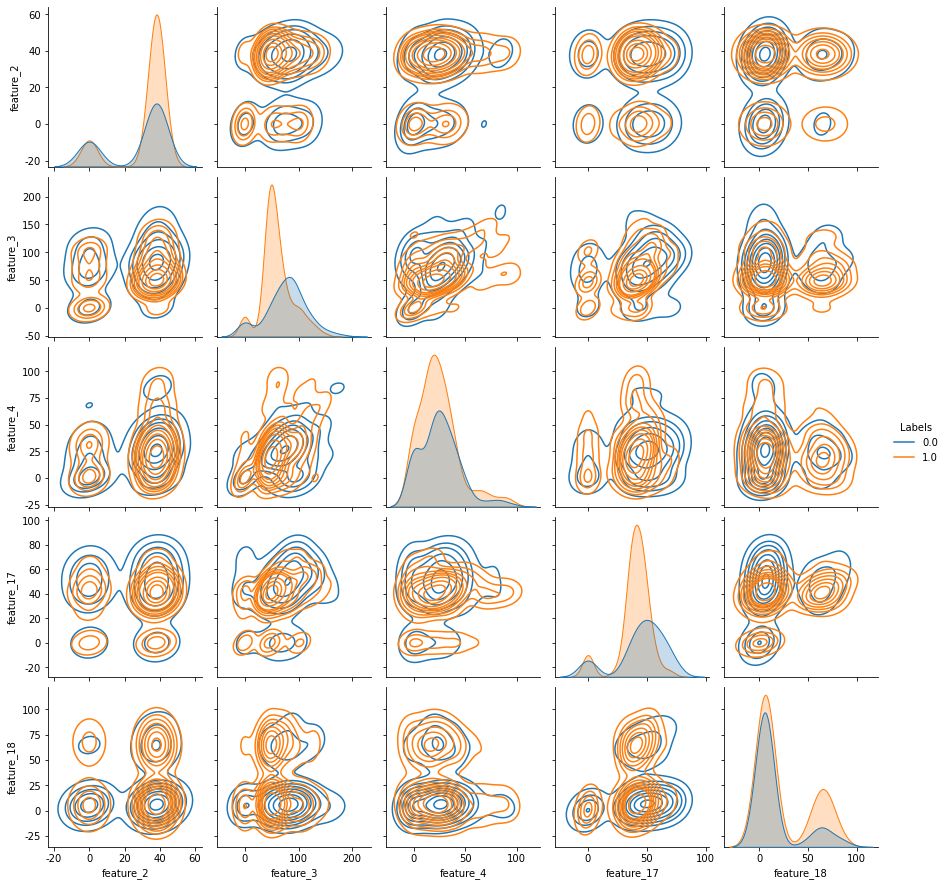

In [12]:
# 绘制连续数值属性的散点图矩阵
g = sns.pairplot(pd.concat([trainDataSet.iloc[:,[2, 3, 4, 17, 18]], trainLabels], axis=1), diag_kind='kde', kind='kde', hue='Labels')
plt.show()

In [13]:
# 导入测试集
with open('./Ch05/horseColicTest.txt') as f:
    data = f.readlines()
    for i, row in enumerate(data):
        if row[-1] == '\n':
            row = row[:-1]
        data[i] = row.split('\t')                  # 按照tab切分

testDataSet = pd.DataFrame(data, columns=['feature_%d'%x for x in range(len(data[0]))]).astype(float)
testLabels = pd.DataFrame(testDataSet.iloc[:,-1]).rename({testDataSet.columns[-1]:'Labels'}, axis=1)
testDataSet = testDataSet.iloc[:,:-1]
testDataSet.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,2.0,1.0,38.5,54.0,20.0,0.0,1.0,2.0,2.0,3.0,...,1.0,2.0,2.0,5.9,0.0,2.0,42.0,6.3,0.0,0.0
1,2.0,1.0,37.6,48.0,36.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,6.3,1.0,5.0
2,1.0,1.0,37.7,44.0,28.0,0.0,4.0,3.0,2.0,5.0,...,4.0,1.0,1.0,0.0,3.0,5.0,45.0,70.0,3.0,2.0
3,1.0,1.0,37.0,56.0,24.0,3.0,1.0,4.0,2.0,4.0,...,3.0,1.0,1.0,0.0,0.0,0.0,35.0,61.0,3.0,2.0
4,2.0,1.0,38.0,42.0,12.0,3.0,0.0,3.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,2.0,37.0,5.8,0.0,0.0


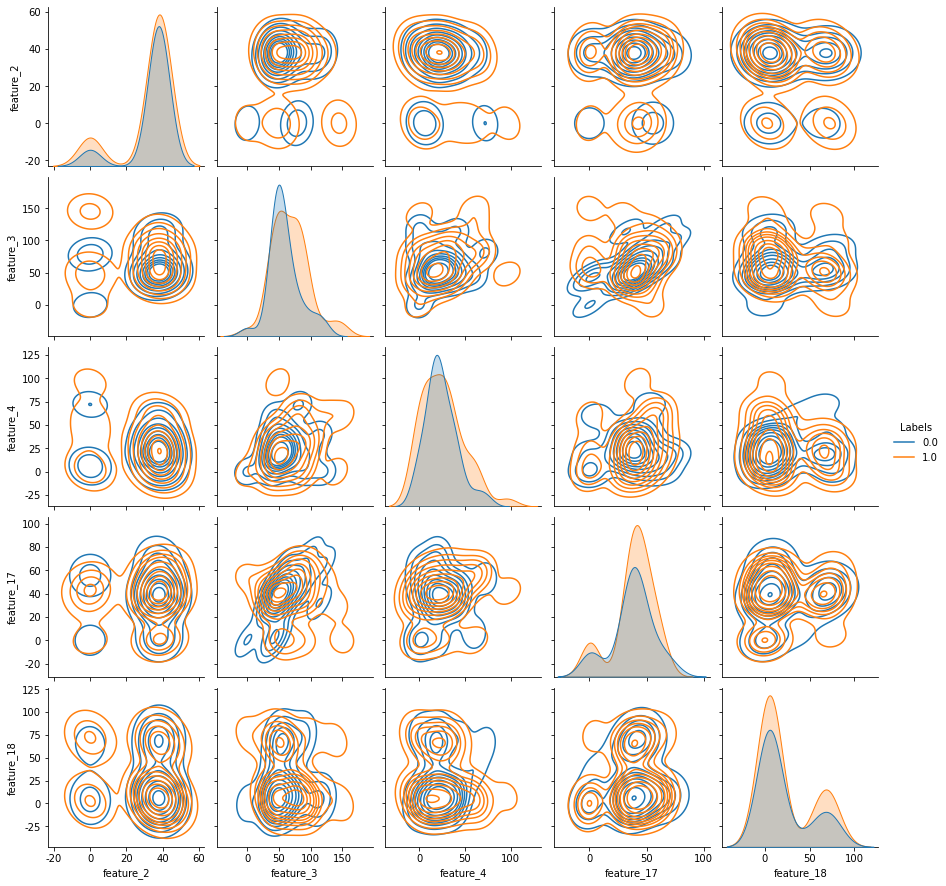

In [14]:
# 绘制连续数值属性的散点图矩阵
g = sns.pairplot(pd.concat([testDataSet.iloc[:,[2, 3, 4, 17, 18]], trainLabels], axis=1), diag_kind='kde', kind='kde', hue='Labels')
plt.show()

### 批量梯度上升

In [ ]:
'''
使用批量梯度上升进行预测
'''
trainWeights = batchGradAscent(trainDataSet.values, trainLabels.values, maxCycles=2000)          # 使用改进的随机梯度上升训练模型
predResult = classifyMatrix(testDataSet.values, trainWeights)                                    # 使用logistic regression回归模型预测测试集
origResult = np.matrix(testLabels.values)                                                        # 获取正确答案

confMatrix, accuracy = calConfMatrix(predResult, origResult)                                     # 计算混淆矩阵和正确率
precision, recall, f1 = calPRF(confMatrix)
print('使用批量梯度上升进行Logistic Regression分类的精确率有{:.03f}%\n准确率：{:.03f}%\n召回率：{:.03f}%\nF1-score：{:.03f}'.format(accuracy * 100, precision * 100, recall * 100, f1))
confMatrix

使用批量梯度上升进行Logistic Regression分类的精确率有70.149%
准确率：90.909%
召回率：63.830%
F1-score：0.750


,one,zero
one,30.0,17.0
zero,3.0,17.0


### 随机梯度上升

In [ ]:
'''
使用改进的随机梯度上升进行预测
'''
trainWeights = stocGradAscentImproved(trainDataSet.values, trainLabels.values, numIter=500)      # 使用改进的随机梯度上升训练模型
predResult = classifyMatrix(testDataSet.values, trainWeights)                                    # 使用logistic regression回归模型预测测试集
origResult = np.matrix(testLabels.values)                                                        # 获取正确答案

confMatrix, accuracy = calConfMatrix(predResult, origResult)                                     # 计算混淆矩阵和正确率
precision, recall, f1 = calPRF(confMatrix)
print('使用随机梯度上升进行Logistic Regression分类的精确率有{:.03f}%\n准确率：{:.03f}%\n召回率：{:.03f}%\nF1-score：{:.03f}'.format(accuracy * 100, precision * 100, recall * 100, f1))
confMatrix

使用随机梯度上升进行Logistic Regression分类的精确率有71.642%
准确率：81.818%
召回率：76.596%
F1-score：0.791


,one,zero
one,36.0,11.0
zero,8.0,12.0


In [ ]:
'''
使用改进的随机梯度上升进行多次预测并取平均值
'''
def stocMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum=10):
    precAvg = 0
    origResult = np.matrix(testLabels.values)
    confMatrixAvg = pd.DataFrame(columns=['one', 'zero'], index=['one', 'zero']).fillna(0)       
    for i in range(roundNum):
        trainWeights = stocGradAscentImproved(trainDataSet.values, trainLabels.values, numIter=500)      # 使用改进的随机梯度上升训练模型
        predResult = classifyMatrix(testDataSet.values, trainWeights)                                    # 使用logistic regression回归模型预测测试集

        confMatrix, accuracy = calConfMatrix(predResult, origResult)       
        confMatrixAvg += confMatrix
        precAvg += accuracy
    
    confMatrixAvg /= roundNum
    precAvg /= roundNum
    
    return confMatrixAvg, precAvg

roundNum = 10
confMatrix, accuracy = stocMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum)
precision, recall, f1 = calPRF(confMatrix)
print('通过迭代运算{}次，使用批量梯度上升进行Logistic Regression分类的精确率有{:.03f}%'.format(roundNum, accuracy * 100))
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confMatrix

通过迭代运算10次，使用批量梯度上升进行Logistic Regression分类的精确率有69.403%
准确率：83.375%
召回率：70.426%
f1：0.764


,one,zero
one,33.1,13.9
zero,6.6,13.4


### 小批量随机梯度上升

In [ ]:
'''
使用小批量随机梯度下降进行预测
'''
trainWeights = miniBatchGradAscent(trainDataSet.values, trainLabels.values)
predResult = classifyMatrix(testDataSet.values, trainWeights)
origResult = np.matrix(testLabels.values)


confMatrix, accuracy = calConfMatrix(predResult, origResult)                                        # 计算混淆矩阵和正确率
precision, recall, f1 = calPRF(confMatrix)
print('使用随机梯度上升进行Logistic Regression分类的精确率有{:.03f}%\n准确率：{:.03f}%\n召回率：{:.03f}%\nF1-score：{:.03f}'.format(accuracy * 100, precision * 100, recall * 100, f1))
confMatrix

使用随机梯度上升进行Logistic Regression分类的精确率有74.627%
准确率：84.091%
召回率：78.723%
F1-score：0.813


,one,zero
one,37.0,10.0
zero,7.0,13.0


In [ ]:
'''
使用小批量随机梯度上升进行多次预测并取平均值
'''
def miniBatchMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum=10, **miniBatchParameters):
    accuracyAvg = 0
    origResult = np.matrix(testLabels.values)
    confMatrixAvg = pd.DataFrame(columns=['one', 'zero'], index=['one', 'zero']).fillna(0)       
    for i in range(roundNum):
        trainWeights = miniBatchGradAscent(trainDataSet.values, trainLabels.values, **miniBatchParameters)    # 使用改进的随机梯度上升训练模型
        predResult = classifyMatrix(testDataSet.values, trainWeights)                                         # 使用logistic regression回归模型预测测试集
        
        confMatrix, accuracy = calConfMatrix(predResult, origResult)
        confMatrixAvg += confMatrix
        accuracyAvg += accuracy
    
    confMatrixAvg /= roundNum
    accuracyAvg /= roundNum
    
    return confMatrixAvg, accuracyAvg

roundNum = 5
miniBatchParameters = {
    'batchSize':50, 
    'gradThreshold':1e-10,  
    'jThreshold':0.95, 
    'maxCycles':2000, 
}
confMatrix, accuracy = miniBatchMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum, **miniBatchParameters)
precision, recall, f1 = calPRF(confMatrix)
print('通过迭代运算{}次，使用改进的随机梯度上升进行Logistic Regression分类的精确率有{:.03f}%'.format(roundNum, accuracy * 100))
print('准确率：{:.02f}'.format(precision * 100))
print('召回率：{:.02f}'.format(recall * 100))
print('F1-Score：{:.02f}'.format(f1))
confMatrix

通过迭代运算5次，使用改进的随机梯度上升进行Logistic Regression分类的精确率有68.358%
准确率：86.44
召回率：65.11
F1-Score：0.74


,one,zero
one,30.6,16.4
zero,4.8,15.2


### 岭回归在Logistic Regression(数学推导)

In [ ]:
'''
将岭回归的思路加入logistic regression的求解中，不使用梯度上升而是直接求出解析解
'''
def ridgeMiniBatchGradAscent(dataMatIn, classLabels, batchSize=100, gradThreshold=1e-10, jThreshold=1e-10, maxCycles=10000):
    # 初始化参数
    m, n = dataMatIn.shape
    dataMatrix = np.matrix(dataMatIn)
    labelMat = np.matrix(np.array(classLabels).reshape((m, 1)))
    weights = np.matrix(np.ones((n, 1)))
    dataIndex = list(range(len(dataMatrix)))
    
    for i in range(maxCycles):
        alpha = 4 / (1.0 + i) + 0.01 # 随着轮数的增加，更新的步幅变小
        # 获取随机小批量数据
        randomIndex = random.sample(dataIndex, batchSize) # b
        batchData = dataMatrix[randomIndex] # b * n
        batchLabels = labelMat[randomIndex] # b * 1

        # 用小批量数据更新weights
        h = sigmoid(batchData * weights) # b * 1
        error = batchLabels - h # b * 1
        if not checkJThreshold(error, jThreshold):
            return weights, i + 1
        gradient = batchData.transpose() * error # n * 1
        if not checkGradThreshold(gradient, gradThreshold):
            return weights, i + 1
        weights += alpha * gradient / 3
    return weights

## 重新清洗数据集并进行Logistic Regression

### 导入原始数据

In [ ]:
trainDataSet = []
testDataSet = []
def cleanBlank(lst):
    while '' in lst:
        lst.remove('')
    return lst
def repUnknown(lst):
    while '?' in lst:
        id = lst.index('?')
        lst[id] = None
    return lst
with open('./Data/horse-colic.data', 'r') as f:
    for row in f.readlines():
        if row[-1] == '\n':
            row = row[:-1]
        row = row.split(' ')
        row = cleanBlank(row)
        row = repUnknown(row)
        trainDataSet.append(row)

with open('./Data/horse-colic.test', 'r') as f:
    for row in f.readlines():
        if row[-1] == '\n':
            row = row[:-1]
        row = row.split(' ')
        row = cleanBlank(row)
        row = repUnknown(row)
        testDataSet.append(row)

columns = ['surgery', 'age', 'hospital_number', 'rectal_temperature', 'pulse', \
    'respiratory_rate', 'temperature_extremities', 'peripheral_pulse', 'mucous_membranes', \
    'capllary_refill_time', 'pain', 'peristalsis', 'abdominal_distension', 'nasogastric_tube', \
    'nasogastric_reflux', 'nasogastric_reflux_PH', 'rectal_examination_feces', 'abdomen', \
    'packed_cell_volume', 'total_protein', 'abdominocentesis_appearance', \
    'abdomcentesis_total_protein', 'outcome', 'surgical_lesion', 'lesion_1', 'lesion_2', \
    'lesion_3', 'cp_data']
trainDataSet = pd.DataFrame(trainDataSet, columns=columns).astype('float')
testDataSet = pd.DataFrame(testDataSet, columns=columns).astype('float')
trainDataSet.head(3)

,surgery,age,hospital_number,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,...,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,2.0,1.0,530101.0,38.5,66.0,28.0,3.0,3.0,NaN,2.0,...,45.0,8.4,NaN,NaN,2.0,2.0,11300.0,0.0,0.0,2.0
1,1.0,1.0,534817.0,39.2,88.0,20.0,NaN,NaN,4.0,1.0,...,50.0,85.0,2.0,2.0,3.0,2.0,2208.0,0.0,0.0,2.0
2,2.0,1.0,530334.0,38.3,40.0,24.0,1.0,1.0,3.0,1.0,...,33.0,6.7,NaN,NaN,1.0,2.0,0.0,0.0,0.0,1.0


### 无效数据删除、选取特征和顺序变换

In [ ]:
'''
清理数据：
删除surgical_lesion列为空的数据

需要被删掉的属性： 
1. Hospital Number: 马的号码
2. outcome
3. lession 1
4. lession 2
5. lession 3
6. cp_data
需要改变顺序的属性：
1. temperature of extremities
2. peripheral pulse
3. rectal examination - feces
4. surgical_lesion
'''

# 删除surgical_lesion为空的数据
trainDataSet = trainDataSet[trainDataSet.surgical_lesion == trainDataSet.surgical_lesion] # 这里利用了np.nan的特性
# trainDataSet = trainDataSet[trainDataSet.surgical_lesion.isna().agg(lambda x:not x)]
testDataSet = testDataSet[testDataSet.surgical_lesion == testDataSet.surgical_lesion]

# 删除不必要的属性 
for column in ['hospital_number', 'outcome', 'lesion_1', 'lesion_2', 'lesion_3', 'cp_data']:
    if column in columns:
        columns.remove(column)
trainDataSet = trainDataSet.loc[:, columns]
testDataSet = testDataSet.loc[:, columns]

# 改变部分离散属性的排列属性
tEMap = {
    4 : 1, 
    3 : 2, 
    1 : 3, 
    2 : 4, 
}
pPMap = {
    4 : 1, 
    3 : 2, 
    1 : 3, 
    2 : 4, 
}
rEFMap = {
    4 : 1, 
    3 : 2, 
    1 : 3, 
    2 : 4, 
}
sLMap = {
    1 : 1, 
    2 : 0, 
}
def transformAttributes(dataframe):
    dataframe['temperature_extremities'] = dataframe['temperature_extremities'].map(lambda x:tEMap[x] if x == x else x)
    dataframe['peripheral_pulse'] = dataframe['peripheral_pulse'].map(lambda x:pPMap[x] if x == x else x)
    dataframe['rectal_examination_feces'] = dataframe['rectal_examination_feces'].map(lambda x:rEFMap[x] if x == x else x)
    dataframe['surgical_lesion'] = dataframe['surgical_lesion'].map(lambda x:sLMap[x] if x == x else x)
    return dataframe

trainDataSet = transformAttributes(trainDataSet)
testDataSet = transformAttributes(testDataSet)
trainDataSet.head(3)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,surgical_lesion
0,2.0,1.0,38.5,66.0,28.0,2.0,2.0,NaN,2.0,5.0,...,NaN,NaN,NaN,2.0,5.0,45.0,8.4,NaN,NaN,0
1,1.0,1.0,39.2,88.0,20.0,NaN,NaN,4.0,1.0,3.0,...,NaN,NaN,NaN,1.0,2.0,50.0,85.0,2.0,2.0,0
2,2.0,1.0,38.3,40.0,24.0,3.0,3.0,3.0,1.0,3.0,...,NaN,NaN,NaN,3.0,1.0,33.0,6.7,NaN,NaN,0


### 缺省值处理（均值填充法）

In [ ]:
'''
使用均值法填充训练集缺省值
'''
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# imputer.fit(trainDataSet)
# trainDataSet = pd.DataFrame(imputer.transform(trainDataSet), columns=trainDataSet.columns).astype('float')
# testDataSet = pd.DataFrame(imputer.transform(testDataSet), columns=trainDataSet.columns).astype('float')
# trainDataSet.head(3)

'\n使用均值法填充训练集缺省值\n'

In [ ]:
'''
使用改进的均值法填充训练集缺省值
'''
# def meanFill(df, columnMeanValue=None):
#     if columnMeanValue == None:
#         columnMeanValue = {column:-1 for column in df.columns}
#     for column in df.columns:
#         columnSeries = df.loc[:, column]
#         columnMeanValue[column] = columnSeries.mean()
#         df.loc[:, column] = columnSeries.fillna(columnMeanValue[column])
#     return df, columnMeanValue
# # 处理训练集
# trueSubSet = trainDataSet[trainDataSet['outcome'] == 0]
# falseSubSet = trainDataSet[trainDataSet['outcome'] == 1]
# trueSubSet, trueMeanValue = meanFill(trueSubSet)
# falseSubSet, falseMeanValue = meanFill(falseSubSet)
# trainDataSet = pd.concat([trueSubSet, falseSubSet], axis=0)
# # 处理测试集
# trueSubSet = testDataSet[testDataSet['outcome'] == 0]
# falseSubSet = testDataSet[testDataSet['outcome'] == 1]
# trueSubSet, trueMeanValue = meanFill(trueSubSet)
# falseSubSet, falseMeanValue = meanFill(falseSubSet)
# testDataSet = pd.concat([trueSubSet, falseSubSet], axis=0)

'\n使用改进的均值法填充训练集缺省值\n'

In [ ]:
class MeanImputer(object):
    def __init__(self, discreteAtts=[]):
        self.cLabels = set()
        self.meanValue = dict()
        self.strictMeanValue = dict()
        self.columns = list()
        self.classLabel = None
        self.discreteAtts = set(discreteAtts)
        self.discreteAttValues = {att:None for att in discreteAtts}
    
    @staticmethod
    def findNeighbour(value, valueLst):
        valueLst = np.abs(np.array(valueLst) - value)
        value = float(np.min(valueLst)) + value
        return value

    def fit(self, dataframe, classLabel=None, discreteIndex=None):
        if classLabel == None:
            classLabel = dataframe.columns[-1]
        self.classLabel = classLabel
        self.cLabels = set(dataframe[classLabel].unique().tolist())
        self.meanValue = {label:dict() for label in self.cLabels}
        self.columns = dataframe.columns.tolist()
        for label in self.cLabels:
            subSet = dataframe[dataframe[classLabel] == label]
            for i, column in enumerate(self.columns):
                if discreteIndex is not None and i in discreteIndex:
                    self.meanValue[label][column] = subSet[column].mean()
                else:
                    self.meanValue[label][column] = subSet[column].value_counts().idxmax()
        self.strictMeanValue = {column:dataframe.loc[:, column].mean() for column in columns}

        if len(self.discreteAtts) > 0:
            for column in self.discreteAtts:
                valueList = dataframe[column].dropna().astype('float').unique().tolist()
                self.discreteAttValues[column] = valueList
    
    def easeTransform(self, dataframe):
        dataframe = dataframe.copy()
        if len(self.meanValue) > 0:
            subSets = []
            for label in self.cLabels:
                subSet = dataframe[dataframe[self.classLabel] == label]
                for column in self.columns:
                    if column not in self.discreteAtts:
                        subSet[column] = subSet[column].fillna(self.meanValue[label][column])
                    else:
                        subSet[column] = subSet[column].fillna(self.findNeighbour(self.meanValue[label][column], self.discreteAttValues[column]))
                subSets.append(subSet)
            return pd.concat(subSets, axis=0)
        else:
            print('You have not fit the dataset yet')
    
    def strictTransform(self, dataframe):
        dataframe = dataframe.copy()
        if len(self.meanValue) > 0:
            for column in self.columns:
                if column not in self.discreteAtts:
                    dataframe[column] = dataframe[column].fillna(self.strictMeanValue[column])
                else:
                    dataframe[column] = dataframe[column].fillna(self.findNeighbour(self.strictMeanValue[column], self.discreteAttValues[column]))
            return dataframe
        else:
            print('You have not fit the dataset yet')

# meanImputer = MeanImputer(discreteAtts=['mucous_membranes', 'abdomen'])
meanImputer = MeanImputer()
discreteAttIndex = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 19, 21]
meanImputer.fit(trainDataSet, classLabel='surgical_lesion', discreteIndex=discreteAttIndex)
trainDataSet = meanImputer.easeTransform(trainDataSet)
testDataSet = meanImputer.easeTransform(testDataSet)
trainDataSet.head(3)

/var/folders/nk/q7smhcns0vz5c_6thgvby85m0000gn/T/ipykernel_25040/3673760701.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subSet[column] = subSet[column].fillna(self.meanValue[label][column])
/var/folders/nk/q7smhcns0vz5c_6thgvby85m0000gn/T/ipykernel_25040/3673760701.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subSet[column] = subSet[column].fillna(self.meanValue[label][column])


,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,surgical_lesion
0,2.0,1.0,38.5,66.0,28.0,2.000000,2.00000,2.333333,2.0,5.0,...,1.723077,1.327869,5.5,2.0,5.0,45.0,8.4,1.585366,1.0,0
1,1.0,1.0,39.2,88.0,20.0,2.733333,2.77381,4.000000,1.0,3.0,...,1.723077,1.327869,5.5,1.0,2.0,50.0,85.0,2.000000,2.0,0
2,2.0,1.0,38.3,40.0,24.0,3.000000,3.00000,3.000000,1.0,3.0,...,1.723077,1.327869,5.5,3.0,1.0,33.0,6.7,1.585366,1.0,0


### 缺省值处理（K邻近）

In [ ]:
'''
K邻近方法预测训练集空值
'''
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=3, weights='distance') # distance适合于连续变量
# imputer.fit(trainDataSet)
# trainDataSet = pd.DataFrame(imputer.transform(trainDataSet), columns=trainDataSet.columns).astype('float')
# testDataSet = pd.DataFrame(imputer.transform(testDataSet), columns=trainDataSet.columns).astype('float')
# trainDataSet.head(3)

'\nK邻近方法预测训练集空值\n'

### 离散属性连续化

In [ ]:
'''
离散属性连续化：
需要连续化的离散属性：
1. mucous membranes
2. abdomen
'''
# def serialize(dataframe):
#     dataframe['MM_fastCirculation'] = dataframe['mucous_membranes'].map(lambda x:1 if x == 1 or x == 2 else 0)
#     dataframe['MM_seriousCirculation'] = dataframe['mucous_membranes'].map(lambda x:1 if x == 4 or x == 6 else 0)
#     dataframe['MM_shock'] = dataframe['mucous_membranes'].map(lambda x:1 if x == 3 else 0)
#     dataframe['MM_septicemia'] = dataframe['mucous_membranes'].map(lambda x:1 if x == 5 else 0)
#     dataframe.drop('mucous_membranes', axis=1, inplace=True)

#     dataframe['ABD_normal'] = dataframe['abdomen'].map(lambda x:1 if x == 1 else 0)
#     dataframe['ABD_other'] = dataframe['abdomen'].map(lambda x:1 if x == 2 else 0)
#     dataframe['ABD_fece'] = dataframe['abdomen'].map(lambda x:1 if x == 3 else 0)
#     dataframe['ABD_surgicalLession'] = dataframe['abdomen'].map(lambda x:1 if x == 4 or x ==5 else 0)
#     dataframe.drop('abdomen', axis=1, inplace=True)
#     return dataframe

# trainDataSet = serialize(trainDataSet)
# testDataSet = serialize(testDataSet)
# trainDataSet.head(5)

'\n离散属性连续化：\n需要连续化的离散属性：\n1. mucous membranes\n2. abdomen\n'

### 归一化处理

In [ ]:
'''
归一化处理
'''
class MinMaxNormalization(object):
    def __init__(self):
        self.maxDict = dict()
        self.minDict = dict()
        self.columns = np.array([])

    def fit(self, dataDF):
        self.__init__()
        self.columns = dataDF.columns
        for column in self.columns:
            self.maxDict[column] = dataDF[column].max()
            self.minDict[column] = dataDF[column].min()
    
    def transform(self, dataDF):
        for column in dataDF:
            dataDF[column] = (dataDF[column] - self.minDict[column]) / (self.maxDict[column] - self.minDict[column])
        return dataDF
    
    def fitTransform(self, dataDF):
        self.fit(dataDF)
        return self.transform(dataDF)

minMaxNormalization = MinMaxNormalization()
trainDataSet = minMaxNormalization.fitTransform(trainDataSet)
testDataSet = minMaxNormalization.fitTransform(testDataSet)
testDataSet.head(3)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,surgical_lesion
0,1.0,0.0,0.675676,0.172414,0.116279,0.577778,0.666667,0.2,1.0,0.500000,...,0.500000,0.500000,0.628571,0.453704,0.25000,0.542857,0.037086,0.292683,0.014085,0.0
1,1.0,0.0,0.432432,0.120690,0.302326,0.577778,0.591270,0.0,0.0,0.306818,...,0.361538,0.163934,0.571429,0.453704,0.41129,0.571429,0.037086,0.000000,0.577465,0.0
3,0.0,0.0,0.270270,0.189655,0.162791,0.333333,0.666667,0.6,1.0,0.750000,...,0.000000,0.000000,0.571429,0.453704,0.41129,0.442857,0.761589,1.000000,0.154930,0.0


### 增加$x_0$列

In [ ]:
trainDataSet['b'] = 1
testDataSet['b'] = 1
trainDataSet.head(3)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,surgical_lesion,b
0,1.0,0.0,0.574074,0.233766,0.227273,0.333333,0.333333,0.266667,0.5,1.0,...,0.163934,0.692308,0.333333,1.00,0.423077,0.059510,0.292683,0.09,0.0,1
1,0.0,0.0,0.703704,0.376623,0.136364,0.577778,0.591270,0.600000,0.0,0.5,...,0.163934,0.692308,0.000000,0.25,0.519231,0.953326,0.500000,0.19,0.0,1
2,1.0,0.0,0.537037,0.064935,0.181818,0.666667,0.666667,0.400000,0.0,0.5,...,0.163934,0.692308,0.666667,0.00,0.192308,0.039673,0.292683,0.09,0.0,1


### 分离训练集和测试集

In [ ]:
'''
分离数据和Labels
'''
# 处理训练集
trainLabels = trainDataSet.loc[:,['surgical_lesion']].rename({'surgical_lesion':'Labels'}, axis=1)
trainDataSet.drop('surgical_lesion', axis=1, inplace=True)

# 处理测试集
testLabels = testDataSet.loc[:,['surgical_lesion']].rename({'surgical_lesion':'Labels'}, axis=1)
testDataSet.drop('surgical_lesion', axis=1, inplace=True)

trainDataSet.head(3)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,b
0,1.0,0.0,0.574074,0.233766,0.227273,0.333333,0.333333,0.266667,0.5,1.0,...,0.361538,0.163934,0.692308,0.333333,1.00,0.423077,0.059510,0.292683,0.09,1
1,0.0,0.0,0.703704,0.376623,0.136364,0.577778,0.591270,0.600000,0.0,0.5,...,0.361538,0.163934,0.692308,0.000000,0.25,0.519231,0.953326,0.500000,0.19,1
2,1.0,0.0,0.537037,0.064935,0.181818,0.666667,0.666667,0.400000,0.0,0.5,...,0.361538,0.163934,0.692308,0.666667,0.00,0.192308,0.039673,0.292683,0.09,1


### 导出和备份数据

In [ ]:
'''
导出&备份数据
'''
with open('./Cache/data_normalization.pkl', 'wb+') as f:
    pickle.dump((trainDataSet.values, trainLabels.values, testDataSet.values, testLabels.values, trainDataSet.columns), f)

## 预测疝气病（重新处理的数据）

### 批量梯度上升

In [51]:
'''
使用批量梯度上升进行预测
'''
trainWeights = batchGradAscent(trainDataSet.values, trainLabels.values)                          # 使用改进的随机梯度上升训练模型
predResult = classifyMatrix(testDataSet.values, trainWeights)                                    # 使用logistic regression回归模型预测测试集
origResult = np.matrix(testLabels.values)                                                        # 获取正确答案

confMatrix, precRate = calConfMatrix(predResult, origResult, )                                   # 计算混淆矩阵和正确率
print('使用改进的随机梯度上升进行Logistic Regression分类的精确率有{:.03f}%'.format(precRate * 100))

precision, recall, f1 = calPRF(confMatrix)
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confMatrix

使用改进的随机梯度上升进行Logistic Regression分类的精确率有91.176%
准确率：90.698%
召回率：95.122%
f1：0.929


,one,zero
one,39.0,2.0
zero,4.0,23.0


### 随机梯度上升

In [52]:
'''
使用改进的随机梯度上升进行多次预测并取平均值
'''
roundNum = 5
confMatrix, precRate = stocMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum)
print('通过迭代运算{}次，使用改进的随机梯度上升进行Logistic Regression分类的精确率有{:.03f}%'.format(roundNum, precRate * 100))
precision, recall, f1 = calPRF(confMatrix)
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confMatrix

通过迭代运算5次，使用改进的随机梯度上升进行Logistic Regression分类的精确率有91.176%
准确率：90.698%
召回率：95.122%
f1：0.929


,one,zero
one,39.0,2.0
zero,4.0,23.0


### 小批量随机梯度上升

In [53]:
roundNum = 5
miniBatchParameters = {
    'batchSize':50, 
    'gradThreshold':-1,  
    'jThreshold':1.1, 
    'maxCycles':2500, 
}
confMatrix, precRate = miniBatchMultiTest(trainDataSet, trainLabels, testDataSet, testLabels, roundNum, **miniBatchParameters)
precision, recall, f1 = calPRF(confMatrix)
print('通过迭代运算{}次，使用改进的小批量梯度上升进行Logistic Regression分类的精确率有{:.03f}%'.format(roundNum, precRate * 100))
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confMatrix

通过迭代运算5次，使用改进的小批量梯度上升进行Logistic Regression分类的精确率有94.118%
准确率：95.122%
召回率：95.122%
f1：0.951


,one,zero
one,39.0,2.0
zero,2.0,25.0


### 交叉验证

In [34]:
wholeDataSet = pd.concat([trainDataSet, testDataSet], axis=0)
wholeLabels = pd.concat([trainLabels, testLabels], axis=0)
wholeDataSet.head(3)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities,peripheral_pulse,mucous_membranes,capllary_refill_time,pain,...,abdominal_distension,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein
0,1.0,0.0,0.574074,0.233766,0.227273,0.333333,0.333333,0.266667,0.5,1.0,...,1.000000,0.361538,0.163934,0.692308,0.333333,1.00,0.423077,0.059510,0.292683,0.09
1,0.0,0.0,0.703704,0.376623,0.136364,0.577778,0.591270,0.600000,0.0,0.5,...,0.333333,0.361538,0.163934,0.692308,0.000000,0.25,0.519231,0.953326,0.500000,0.19
2,1.0,0.0,0.537037,0.064935,0.181818,0.666667,0.666667,0.400000,0.0,0.5,...,0.000000,0.361538,0.163934,0.692308,0.666667,0.00,0.192308,0.039673,0.292683,0.09


In [98]:
# kFold
def kFold(dataSet, labels, k, randomShuffle=True):
    dataSet = pd.concat([dataSet, labels], axis=1)
    labelName = dataSet.columns[-1]
    attNames = dataSet.columns.drop(labelName)
    index = set(range(len(dataSet)))
    dataSet.sort_values(by=labelName, inplace=True)

    if randomShuffle == True:
        labelSubSet = {label:dataSet[dataSet[labelName] == label] for label in dataSet[labelName].unique()}
        labelSubSet = [labelSubSet[label].iloc[np.random.permutation(len(labelSubSet[label]))] for label in labelSubSet]
        dataSet = pd.concat(labelSubSet, axis=0)

    for i in range(k):
        testIndex = set(range(i, len(dataSet), k))
        trainSubSet = dataSet.iloc[list(index - testIndex)]
        testSubSet = dataSet.iloc[list(testIndex)]
        yield trainSubSet[attNames], trainSubSet[[labelName]], testSubSet[attNames], testSubSet[[labelName]]

k = 10
miniBatchParameters = {
    'batchSize':50, 
    'gradThreshold':-1,  
    'jThreshold':1.1, 
    'maxCycles':2500, 
}
roundNum = 5
confMatrixAvg = pd.DataFrame(columns=['one', 'zero'], index=['one', 'zero']).fillna(0)
precRateAvg = 0
for trainSubData, trainSubLabels, testSubData, testSubLabels in kFold(wholeDataSet, wholeLabels, k):
    confMatrix, precRate = miniBatchMultiTest(trainSubData, trainSubLabels, testSubData, testSubLabels, roundNum, **miniBatchParameters)
    confMatrixAvg += confMatrix
    precRateAvg += precRate

confMatrixAvg /= k
precRateAvg = precRateAvg / k
print('经过{}-折交叉验证，发现小批量梯度上升的Logistic Regression对该数据集的预测精确率为：{:.02f}%'.format(k, precRateAvg * 100))
precision, recall, f1 = calPRF(confMatrixAvg)
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confMatrixAvg

经过10-折交叉验证，发现小批量梯度上升的Logistic Regression对该数据集的预测精确率为：93.10%
准确率：94.874%
召回率：94.138%
f1：0.945


,one,zero
one,21.84,1.36
zero,1.18,12.42


## 模型探索(这一部分不能用归一化的数据，显示效果会不好)

### 时间-准确度

In [36]:
import time
def miniBatchMultiTime(trainDataSet, trainLabels, testDataSet, testLabels, roundNum=10, **miniBatchParameters):
    precAvg = 0
    origResult = np.matrix(testLabels.values)
    confMatrixAvg = pd.DataFrame(columns=['zero', 'one'], index=['zero', 'one']).fillna(0)
    times = []
    for i in range(roundNum):
        startTime = time.time()
        trainWeights = miniBatchGradAscent(trainDataSet.values, trainLabels.values, **miniBatchParameters)      # 使用改进的随机梯度上升训练模型
        endTime = time.time()
        times.append(endTime - startTime)
        predResult = classifyMatrix(testDataSet.values, trainWeights)                                    # 使用logistic regression回归模型预测测试集

        confMatrix, precRate = calConfMatrix(predResult, origResult)        
        confMatrixAvg += confMatrix
        precAvg += precRate
    
    confMatrixAvg /= roundNum
    precAvg /= roundNum
    timeAvg = np.average(times)
    
    return confMatrixAvg, precAvg, timeAvg

basicPara = {
    'gradThreshold':-1,  
    'jThreshold':1.1, 
    'maxCycles':2500, 
}
precisions = []
times = []
for i in range(10, 300, 10):
    basicPara['batchSize'] = i
    _conf, precAvg, timeAvg = miniBatchMultiTime(trainDataSet, trainLabels, testDataSet, testLabels, roundNum, **basicPara)
    precisions.append(precAvg)
    times.append(timeAvg)


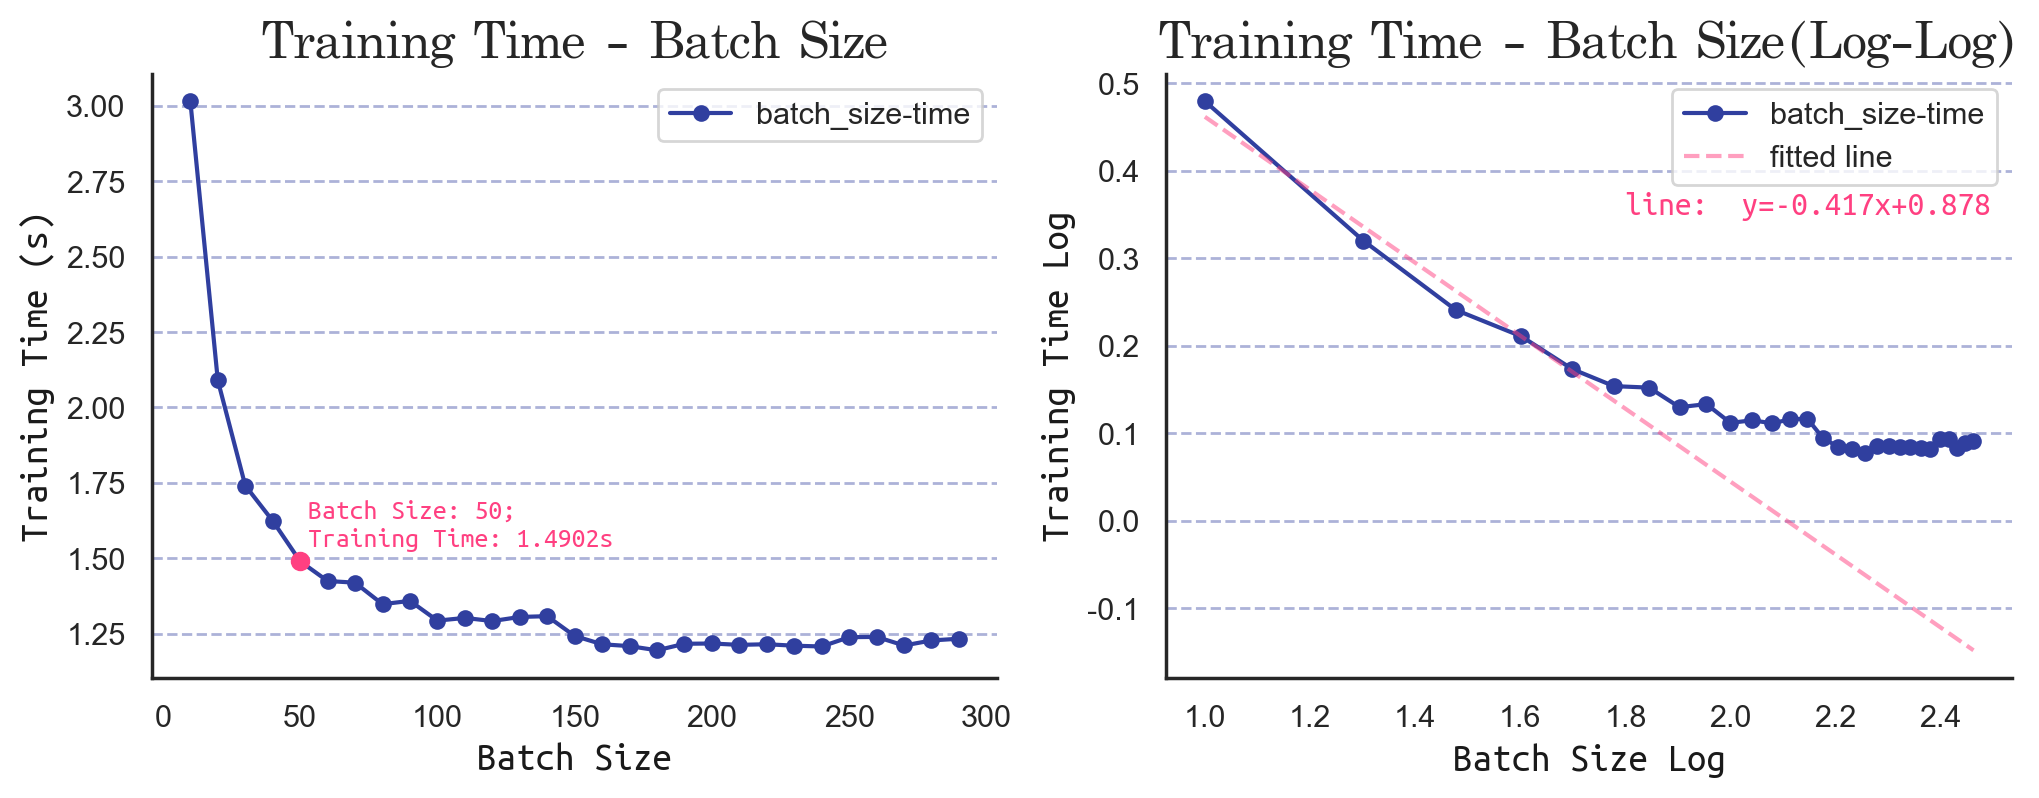

In [209]:
timePrecision = pd.DataFrame([range(10, 300, 10), times, precisions]).T.astype('float')
timePrecision.columns = ['Batch_Size', 'Time', 'Precision']
timePrecision['Time_log'] = timePrecision['Time'].apply(np.log10)
timePrecision['Batch_Size_log'] = timePrecision['Batch_Size'].apply(np.log10)
fig, (ax1, ax2)= plt.subplots(1, 2, dpi=200, figsize=(12, 4))
sns.lineplot(data=timePrecision, x='Batch_Size', y='Time', ax=ax1, color='#303F9F', marker='o',\
    markeredgewidth=0, markeredgecolor='#303F9F', label='batch_size-time', legend='full')
sns.lineplot(data=timePrecision, x='Batch_Size_log', y='Time_log', ax=ax2, color='#303F9F', marker='o',\
    markeredgewidth=0, markeredgecolor='#303F9F', label='batch_size-time', legend='full')
sns.set_theme(style='white')
ax1.grid(True, ls='--', alpha=0.4, c='#303F9F', axis='y')
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('Batch Size', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax1.set_ylabel('Training Time (s)', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax1.set_title('Training Time - Batch Size', fontsize=18, fontfamily=['AppleMyungjo'])
ax2.grid(True, ls='--', alpha=0.4, c='#303F9F', axis='y')
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_xlabel('Batch Size Log', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax2.set_ylabel('Training Time Log', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax2.set_title('Training Time - Batch Size(Log-Log)', fontsize=18, fontfamily=['AppleMyungjo'])
trainingTimeBest = timePrecision.loc[timePrecision['Batch_Size'] == 50]['Time'].tolist()[0]
ax1.annotate('Batch Size: {};\nTraining Time: {:.04f}s'.format(50, trainingTimeBest),\
    (53, trainingTimeBest + 0.05), fontsize=10, fontfamily=['Ubuntu Mono derivative Powerline'],\
    c='#FF4081', zorder=5)
ax1.scatter(x=[50], y=[trainingTimeBest], c='#FF4081', zorder=10)
paras = np.polyfit(timePrecision['Batch_Size_log'][:6], timePrecision['Time_log'][:6], 1)
fittedLine = np.polyval(paras, timePrecision['Batch_Size_log'])
ax2.plot(timePrecision['Batch_Size_log'], fittedLine, color='#FF4081', ls='--', alpha=0.5, label='fitted line')
ax2.annotate('line:  y={:.03f}x+{:.03f}'.format(paras[0], paras[1]),\
    (1.8, 0.35), fontsize=12, fontfamily=['Ubuntu Mono derivative Powerline'],\
    c='#FF4081', zorder=5)
plt.legend()
plt.show()

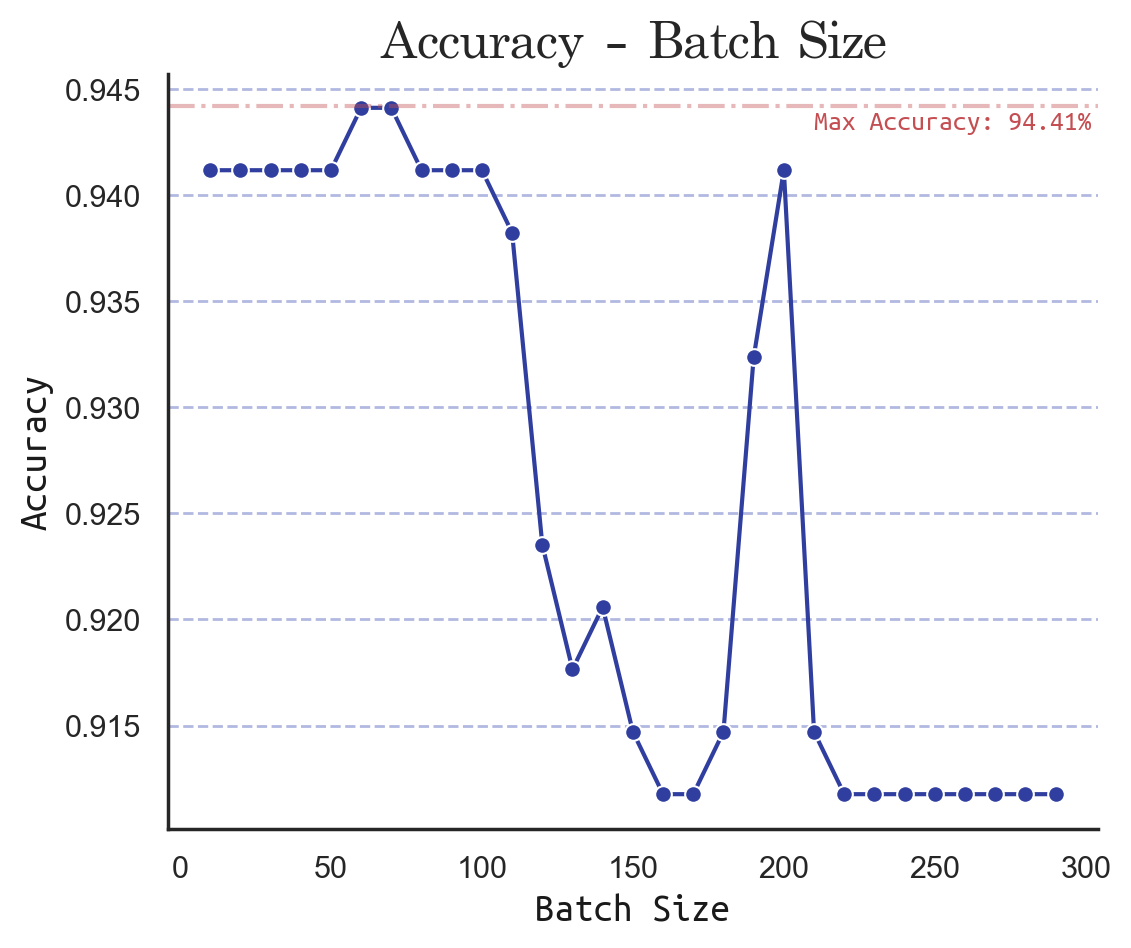

In [215]:
fig, ax= plt.subplots(1, 1, dpi=200, figsize=(6, 5))
sns.set_theme(style='white')
sns.lineplot(data=timePrecision, x='Batch_Size', y='Precision', ax=ax, color='#303F9F', marker='o',\
 markerfacecolor='#303F9F')
maxPrecision = np.max(timePrecision['Precision'])
maxTimes = timePrecision[timePrecision['Precision'] == maxPrecision]['Time']
ax.grid(True, ls='--', color='#3F51B5', alpha=0.4, axis='y')
ax.axhline(maxPrecision + 1e-4, c='r', alpha=0.4, ls='-.')
ax.set_xlabel('Batch Size', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax.set_ylabel('Accuracy', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax.set_xticklabels(['{:.02f}' for acc in timePrecision['Precision']])
ax.set_title('Accuracy - Batch Size', fontsize=18, fontfamily=['AppleMyungjo'])
ax.spines[['right', 'top']].set_visible(False)
ax.text(210, maxPrecision-0.001,  'Max Accuracy: {:.02f}%'.format(maxPrecision * 100), fontsize=10,\
     fontfamily=['Ubuntu Mono derivative Powerline'], c='r')
plt.show()

/var/folders/nk/q7smhcns0vz5c_6thgvby85m0000gn/T/ipykernel_30281/16666352.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=['{:.01f}%'.format(x / 10) for x in range(850, 885, 5)])


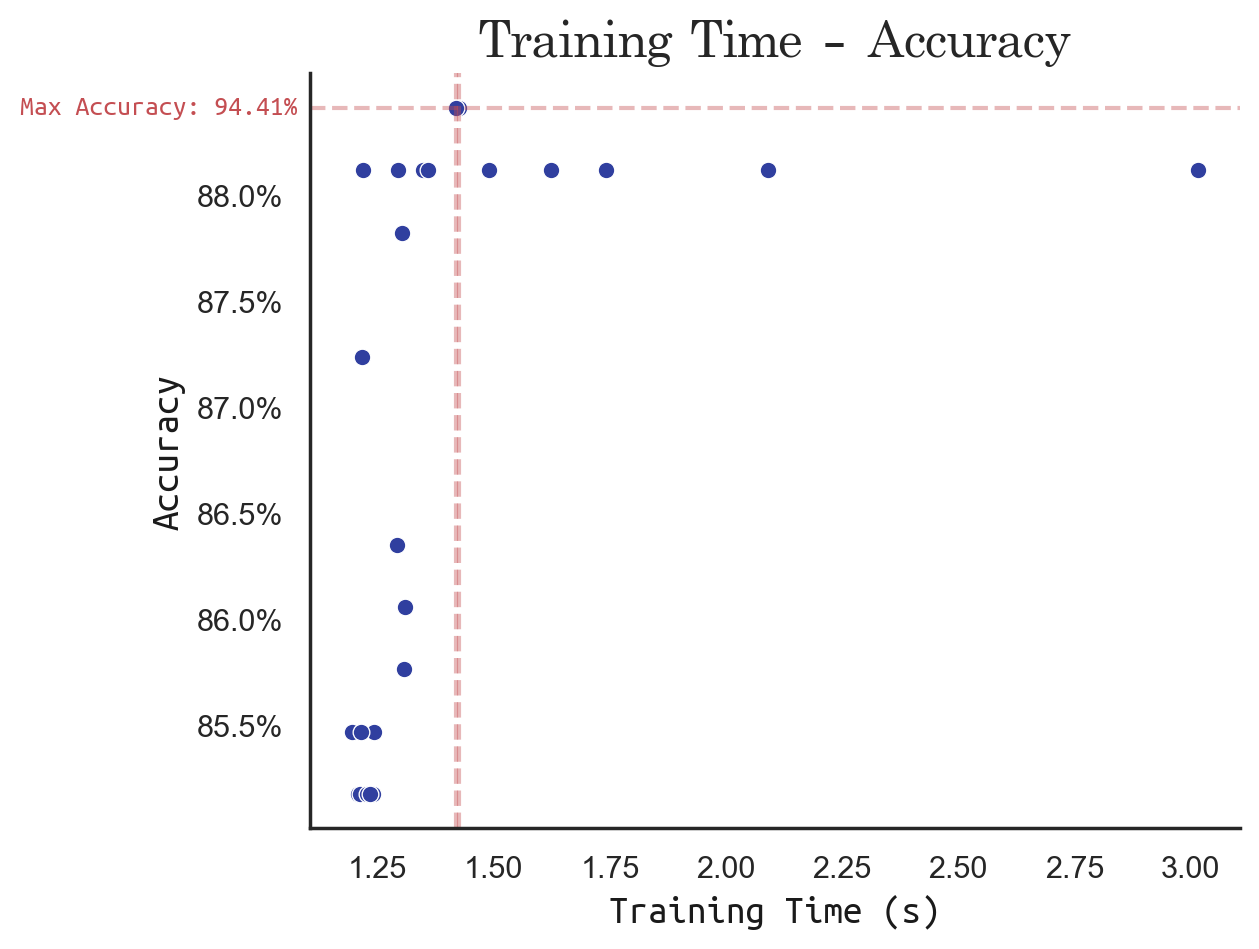

In [156]:
fig, ax= plt.subplots(1, 1, dpi=200, figsize=(6, 5))
sns.scatterplot(data=timePrecision, x='Time', y='Precision', ax=ax, color='#303F9F')
ax.axhline(maxPrecision, c='r', alpha=0.4, ls='--')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Training Time (s)', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax.set_ylabel('Accuracy', fontsize=14, color='k', fontfamily=['Ubuntu Mono derivative Powerline'])
ax.set_title('Training Time - Accuracy', fontsize=18, fontfamily=['AppleMyungjo'])
ax.set_yticklabels(labels=['{:.01f}%'.format(x / 10) for x in range(850, 885, 5)])
ax.text(0.48, maxPrecision-0.0003,  'Max Accuracy: {:.02f}%'.format(maxPrecision * 100), fontsize=10, fontfamily=['Ubuntu Mono derivative Powerline'], c='r')

for maxTime in maxTimes:
    ax.axvline(maxTime, c='r', alpha=0.4, ls='--')
plt.show()

### 精确率随迭代次数的变化

In [40]:
def plotTrack(precRatesSmooth, testPrecRatesSmooth):
    trainMaxPrec = np.max(np.array(precRatesSmooth).T[1])
    xIndex = 0.85 * precRatesSmooth[-1][0]
    testMaxPrec = np.max(np.array(testPrecRatesSmooth).T[1])
    trainMinPrec = np.min(np.array(precRatesSmooth).T[1])
    testMinPrec = np.min(np.array(testPrecRatesSmooth).T[1])
    
    yLim = (np.min([trainMinPrec // 0.05 * 0.05, testMinPrec // 0.05 * 0.05]), np.max([(trainMaxPrec // 0.05 + 1) * 0.05, (testMaxPrec // 0.05 + 1) * 0.05]))
    errorData = pd.DataFrame(precRatesSmooth).astype('float').dropna()
    testErrorData = pd.DataFrame(testPrecRatesSmooth).astype('float').dropna()
    errorData.columns = ['roundNum', 'train_precision', 'floor', 'ceil']
    testErrorData.columns = ['roundNum', 'test_precision', 'floor', 'ceil']

    sns.set_theme(style="white")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
    sns.lineplot(data=errorData, x='roundNum', y='train_precision', ax=ax1)
    sns.lineplot(data=testErrorData, x='roundNum', y='test_precision', ax=ax2)
    ax1.fill_between(errorData['roundNum'].tolist(), errorData['floor'].tolist(), errorData['ceil'].tolist(), where=errorData.floor <= errorData.ceil, facecolor='blue', alpha=0.4)
    ax2.fill_between(testErrorData['roundNum'].tolist(), testErrorData['floor'].tolist(), testErrorData['ceil'].tolist(), where=testErrorData.floor <= testErrorData.ceil,\
        facecolor='orange', alpha=0.4)
    ax1.set_yticks(np.arange(yLim[0], yLim[1] + 0.05, 0.05))
    ax1.set_ylim(yLim[0], yLim[1])
    ax2.set_yticks(np.arange(yLim[0], yLim[1] + 0.05, 0.05))
    ax2.set_ylim(yLim[0], yLim[1])
    ax1.axhline(trainMaxPrec, alpha=0.6, c='r')
    ax1.text(xIndex, 1.01*trainMaxPrec, 'Max: {:.02f}'.format(trainMaxPrec * 100), c='r')
    ax1.axhline(trainMinPrec, alpha=0.6, c='b')
    ax2.axhline(testMaxPrec, alpha=0.6, c='r')
    ax2.text(xIndex, 1.01*testMaxPrec, 'Max: {:.02f}'.format(testMaxPrec * 100), c='r')
    ax2.axhline(testMinPrec, alpha=0.6, c='b')
    ax1.grid(ls='--', axis='x', c='grey', lw=0.5, alpha=0.5)
    ax2.grid(ls='--', axis='x', c='grey', lw=0.5, alpha=0.5)

    plt.show()

In [41]:
'''
导入未归一化的数据
'''
with open('./Cache/data.pkl', 'rb') as f:
    trainDataSetUN, trainLabelsUN, testDataSetUN, testLabelsUN, columnsUN = pickle.load(f)
    trainDataSetUN = pd.DataFrame(trainDataSetUN, columns=columnsUN)
    testDataSetUN = pd.DataFrame(testDataSetUN, columns=columnsUN)
    trainLabelsUN = pd.DataFrame(trainLabelsUN, columns=['Labels'])
    testLabelsUN = pd.DataFrame(testLabelsUN, columns=['Labels'])

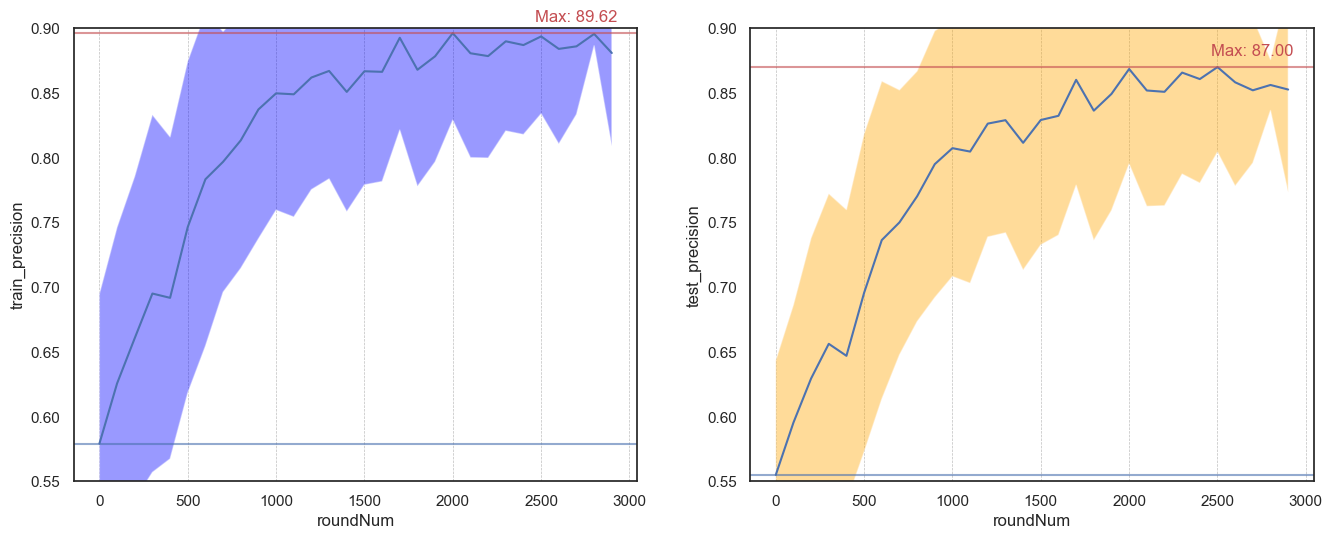

In [42]:
def batchGradAscentTrack(dataMatIn, classLabels, testData, testLabel, alpha=0.01, maxCycles=2000):
    # 将输入转化为np的matrix数据类型
    dataMatrix = np.matrix(dataMatIn, copy=True)
    labelMat = np.matrix(classLabels)

    m, n = dataMatrix.shape
    weights = np.ones((n, 1))                                  # 将权重初始化为1
    precRates = []
    testPrecRates = []

    # 循环进行梯度上升，最多循环maxCycles次
    for k in range(maxCycles):
        h = sigmoid(dataMatrix * weights)                      # 计算当前weights下logistic regression分类结果
        error = (labelMat - h)                                 # 计算当前weights下的误差
        weights += alpha * dataMatrix.transpose() * error      # 梯度上升

        precRates.append(1 - calErrorRate(error))
        testPred = classifyMatrix(testData, weights)
        testPrecRate = calPrecRate(testPred, testLabel)
        testPrecRates.append(testPrecRate)
    return weights, precRates, testPrecRates

weights, precRates, testPrecRates = batchGradAscentTrack(trainDataSetUN.values, trainLabelsUN.values, testDataSetUN.values, testLabelsUN.values, maxCycles=3000)
precRatesSmooth = smoothLine(precRates, 100)
testPrecRatesSmooth = smoothLine(testPrecRates, 100)
plotTrack(precRatesSmooth, testPrecRatesSmooth)

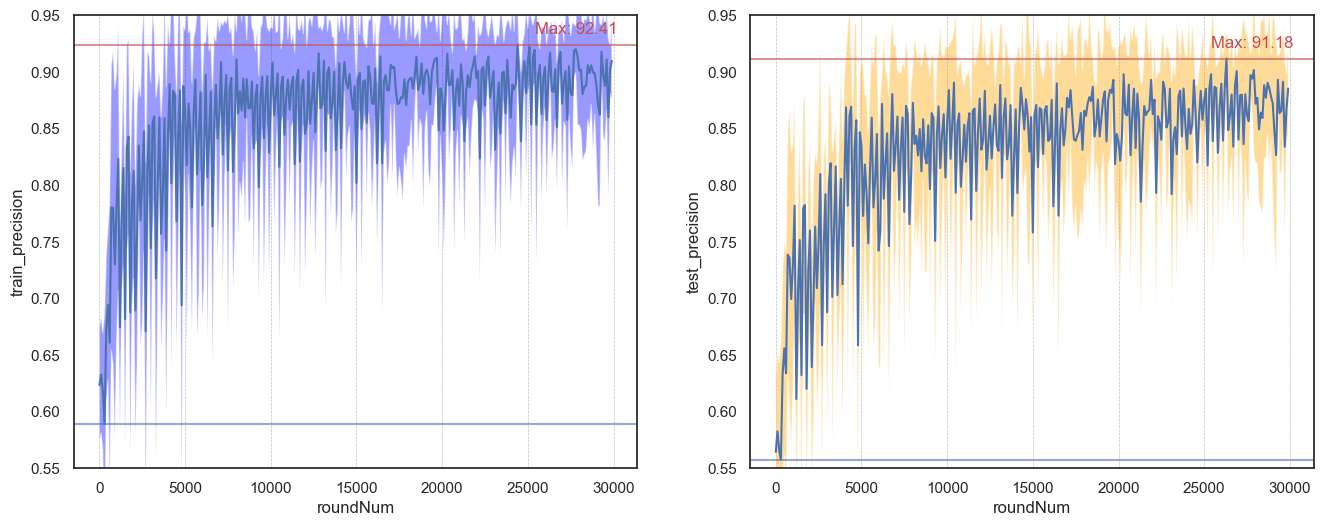

In [43]:
def stocGradAscentImprovedTrack(dataMatIn, classLabels, testData, testLabel, numIter=150):
    # 将输入转化为np的matrix数据类型
    dataMatrix = np.matrix(dataMatIn, copy=True)
    labelMat = list(classLabels.ravel())
    m, n = dataMatrix.shape
    
    weights = np.ones((n, 1))                                                   # 生成初始weights
    precRates = []
    testPrecRates = []

    # 外循环：numIter次
    for j in range(numIter):
        dataIndex = list(range(m))
        # 内循环：dataMatrix行数
        for i in range(m):
            alpha = 4 / (1.0 + j + i) + 0.01                                    # 随着轮数的增加，更新的步幅变小
            randIndex = dataIndex.pop(random.randint(0, len(dataIndex) - 1))    # 获取dataMatrix中的随机一行
            # 更新weights                                                        #（不放回抽样）
            h = sigmoid(dataMatrix[randIndex] * weights)
            error = float(labelMat[randIndex] - h)
            weights += alpha * error * dataMatrix[randIndex].reshape((n, 1))

            testPred = classifyMatrix(testData, weights)
            testPrecRate = calPrecRate(testPred, testLabel)
            testPrecRates.append(testPrecRate)

            trainPred = classifyMatrix(dataMatrix, weights)
            precRate = calPrecRate(trainPred, classLabels)
            precRates.append(precRate)
    return weights, precRates, testPrecRates

weights, precRates, testPrecRates = stocGradAscentImprovedTrack(trainDataSetUN.values, trainLabelsUN.values, testDataSetUN.values, testLabelsUN.values, numIter=100)
precRatesSmooth = smoothLine(precRates, 100)
testPrecRatesSmooth = smoothLine(testPrecRates, 100)
plotTrack(precRatesSmooth, testPrecRatesSmooth)

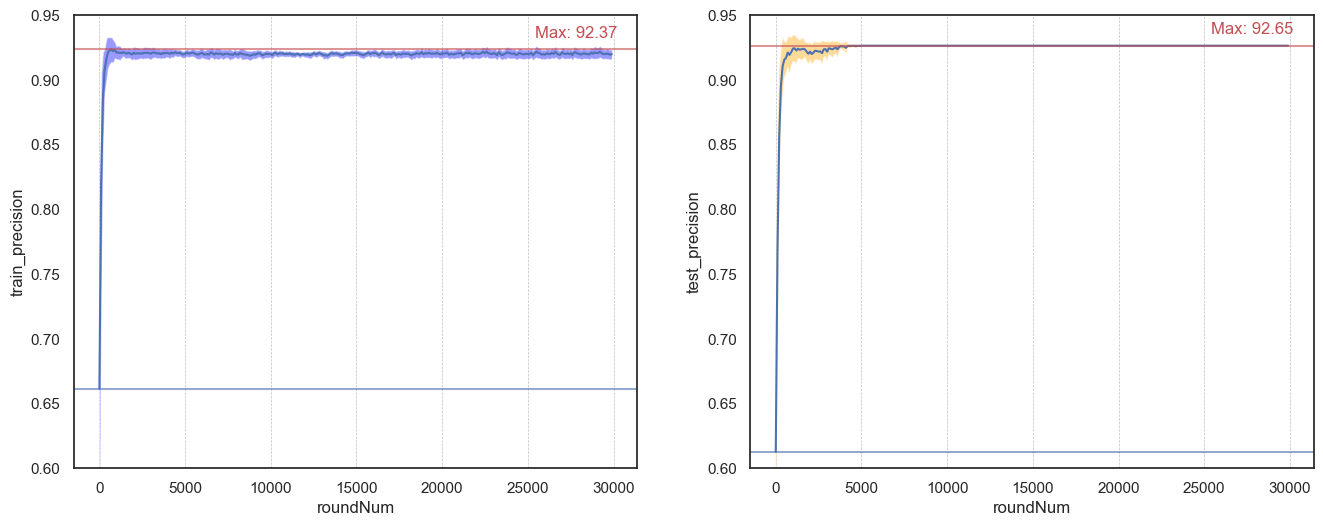

In [44]:
def miniBatchGradAscentTrack(dataMatIn, classLabels, testData, testLabel, batchSize=10, maxCycles=2000):
    # 初始化参数
    m, n = dataMatIn.shape
    dataMatrix = np.matrix(dataMatIn)
    labelMat = np.matrix(np.array(classLabels).reshape((m, 1)))
    weights = np.matrix(np.ones((n, 1)))
    dataIndex = list(range(len(dataMatrix)))
    precRates = []
    testPrecRates = []
    
    # 最多循环maxCycles次
    for i in range(maxCycles):
        dataIndex = list(range(m))
        random.shuffle(dataIndex)
        # 获取随机小批量数据
        for j in range(math.floor(m / batchSize) + 1):
            randomIndex = dataIndex[batchSize * j:batchSize * j + batchSize]       # b，从数据中抽取batchSize行用于更新数据
            if len(randomIndex) > 0:
                alpha = 1 / (1.0 + i)                                              # 随着轮数的增加，更新的步幅变小
                batchData = dataMatrix[randomIndex]                                # b * n
                batchLabels = labelMat[randomIndex]                                # b * 1

                # 用小批量数据更新weights
                h = sigmoid(batchData * weights)                                   # b * 1
                error = batchLabels - h                                            # b * 1
                gradient = batchData.transpose() * error                           # n * 1
                weights += alpha * gradient

                testPred = classifyMatrix(testData, weights)
                testPrecRate = calPrecRate(testPred, testLabel)
                testPrecRates.append(testPrecRate)

                trainPred = classifyMatrix(dataMatrix, weights)
                precRate = calPrecRate(trainPred, classLabels)
                precRates.append(precRate)

    return weights, precRates, testPrecRates

weights, precRates, testPrecRates = miniBatchGradAscentTrack(trainDataSetUN.values, trainLabelsUN.values, testDataSetUN.values, testLabelsUN.values, batchSize=50, maxCycles=5000)
precRatesSmooth = smoothLine(precRates, 100)
testPrecRatesSmooth = smoothLine(testPrecRates, 100)
plotTrack(precRatesSmooth, testPrecRatesSmooth)

## Scikit-Learn 实现

### Scikit Learn实现Logistic Regression算法

In [217]:
'''
通过scikit-learn实现Logistic Regression模型
'''
from sklearn.linear_model import LogisticRegression
logiRegModel = LogisticRegression(random_state=0, tol=1e-5, C=1, fit_intercept=True, solver='liblinear')
logiRegModel.fit(trainDataSet.values, trainLabels.values.T[0])
predictResult = logiRegModel.predict(testDataSet.values)
confM, precision = calConfMatrix(predictResult.reshape(-1, 1), testLabels.values)
print('使用scikit-learn的算法进行Logistic Regression分类，准确率有{:.03f}%'.format(precision * 100))
precision, recall, f1 = calPRF(confM)
print('准确率：{:.03f}%'.format(precision * 100))
print('召回率：{:.03f}%'.format(recall * 100))
print('f1：{:.03f}'.format(f1))
confM

使用scikit-learn的算法进行Logistic Regression分类，准确率有92.647%
准确率：90.909%
召回率：97.561%
f1：0.941


,one,zero
one,40.0,1.0
zero,4.0,23.0


## 集成算法的实现

In [55]:
from BaggingLR import BaggingLR

with open('./Cache/data_normalization.pkl', 'rb') as f:
    trainDataSetTE, trainLabelsTE, testDataSetTE, testLabelsTE, columnsTE = pickle.load(f)
    trainDataSetTE = pd.DataFrame(trainDataSetTE, columns=columnsTE)
    testDataSetTE = pd.DataFrame(testDataSetTE, columns=columnsTE)
    trainLabelsTE = pd.DataFrame(trainLabelsTE, columns=['Labels'])
    testLabelsTE = pd.DataFrame(testLabelsTE, columns=['Labels'])

bagNum = 10
attributeNum = 13
baggingLR = BaggingLR(bagNum, attributeNum)
startTime = time.time()
baggingLR.fit(trainDataSetTE, trainLabelsTE.values.T, jThreshold=0.95, batchSize=50)
predictResult = baggingLR.predict(testDataSetTE)
endTime = time.time()
confMatrix, accuracy = calConfMatrix(predictResult.reshape((-1, 1)), testLabelsTE.values)
print('通过random算法获取{}个子logistic regression分类器，每个分类器对{}个属性进行运算\n使用改进的小批量梯度上升进行Logistic Regression分类\
    \n通过投票方式获取最终分类结果\n精确率有{:.03f}%\n共计耗时{:.03f}秒'.format(bagNum, attributeNum, accuracy * 100, endTime -  startTime))

通过random算法获取10个子logistic regression分类器，每个分类器对13个属性进行运算
使用改进的小批量梯度上升进行Logistic Regression分类
通过投票方式获取最终分类结果
精确率有94.118%
共计耗时4.939秒


In [77]:
from BaggingLR import BaggingLR

with open('./Cache/data_outcome.pkl', 'rb') as f:
    trainDataSetTE, trainLabelsTE, testDataSetTE, testLabelsTE, columnsTE = pickle.load(f)
    trainDataSetTE = pd.DataFrame(trainDataSetTE, columns=columnsTE)
    testDataSetTE = pd.DataFrame(testDataSetTE, columns=columnsTE)
    trainLabelsTE = pd.DataFrame(trainLabelsTE, columns=['Labels'])
    testLabelsTE = pd.DataFrame(testLabelsTE, columns=['Labels'])

bagNum = 10
attributeNum = 13
baggingLR = BaggingLR(bagNum, attributeNum)
startTime = time.time()
baggingLR.fit(trainDataSetTE, trainLabelsTE.values.T, jThreshold=0.95, batchSize=50)
predictResult = baggingLR.predict(testDataSetTE)
endTime = time.time()
confMatrix, accuracy = calConfMatrix(predictResult.reshape((-1, 1)), testLabelsTE.values)
print('通过random算法获取{}个子logistic regression分类器，每个分类器对{}个属性进行运算\n使用改进的小批量梯度上升进行Logistic Regression分类\
    \n通过投票方式获取最终分类结果\n精确率有{:.03f}%\n共计耗时{:.03f}秒'.format(bagNum, attributeNum, accuracy * 100, endTime -  startTime))

通过random算法获取10个子logistic regression分类器，每个分类器对13个属性进行运算
使用改进的小批量梯度上升进行Logistic Regression分类
通过投票方式获取最终分类结果
精确率有92.537%
共计耗时4.918秒


## 回归

### 导入回归使用的连续数据集（波士顿房价数据集）

In [47]:
regData = pd.read_csv('./Data/boston_housing.csv')
regLabel = regData.iloc[:, [-1]]
regData = regData.iloc[:, :-1]
regData.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [48]:
regLabel = regData[['lstat']]
regData = regData.drop('lstat', axis=1)

### 线性回归

In [49]:
def standReg(inX, inY):
    inX = np.matrix(inX)
    inY = np.matrix(inY)
    xTx = inX.T * inX
    
    if np.linalg.det(xTx) != 0:
        weights = xTx.I * (inX.T * inY)
        return weights
    else:
        print('The Matrix is singular, cannot do inverse')

np.matrix(regData.values[2]) * standReg(regData.values, regLabel.values)

matrix([[6.97898249]])